Copyright (C) 2022 Victor Buendia
This program comes with ABSOLUTELY NO WARRANTY;
This is free software, and you are welcome to redistribute it
under certain conditions; see the LICENSE file for details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Numerical Stochastic Processes 101
## A small tutorial for WWCS2022

## 1. From Markov processes to Stochastic Differential Equations

Let me first introduce some basic concepts about stochastic processes and how to deal with them. This will prove relevant when manipulating our equations in order to simulate them -or even to obtain some analytical results. We will stick just to the basics  and will provide no mathematical demonstrations. If you want to check mathematical details, I strongly recommend the book on stochastic processes by Raul Toral and Pere Colet. Most advanced mathematical texts are the textbooks by Gardiner, and van Kampen.

The first process we will introduce is a Markov process. A simple way to visualize a Markov process is to think of a system that can display several different "states". States can be either discrete or continuous. Some examples of what we understand by "states" are the following:

1. An ionic channel in a neuron can be open or closed.
2. In an epidemy, we can consider individuals to be susceptible to contract the infection, infected, or recovered. These would be three different states.
3. A population of bacteria can have 0,1,2,3... individuals. The number of individuals can be identified with states -we would have $\mathbb{N}$ states.
4. A virus can evolve to have different tranmissabilities. Each possible value would be correspond to an state -hence being a continuous spectrum.

The state of the system can evolve through time. Such evolution is described by transition rates, which tell us the _probability per unit time_ of transitioning from one state to another (and has units of 1/seconds). Suppose, for example, that the typical time at which an ionic channel closes is 5.0 ms. This means that the probability distribution for the channel to close at a time $t$ is given by an exponential distribution, $p(t)=5\exp(t/5)$. The rate at which the transition happens is given by the inverse of the typical time -the average of the distribution- which is given by 0.2 ms$^{-1}$. 

A stochastic process is said to be Markovian if the transition rates are independent of time.** This means that the process has no memory: it does not remember how much time has passed since it arrived to its current state. It only knows that it is now in this state, and it is just waiting to jump to a different one. A state can transition to multiple different states, and the choice is randomly selected. The Markov process is perfectly well-defined if we know all its states the transitions among them. Therefore, usual ways of describing a Markov process are using "chemical reactions", or a Markov matrix $\hat W$ such that the element $W_{ij}$ contains the rate of transition from state $i$ to state $j$.

For the sake of an example, we are going to focus in bacterial population growth as a simple example. We are going to simulate our own virtual bacterial colony!

### A simple bacterial population

The most important variable for us is the number of bacteria in our system, $n$. We will assume that bacteria divide by mithosis at a rate $\lambda$, and die at a rate $\beta$. Moreover, we will assume that the bacteria live in a Petri dish that has a finite amount of resources, $n_R$, so each new bacteria appearing needs to occupy a small space in the dish. If there is resources around, a bacteria will not be able to reproduce.  A single bacteria can then either reproduce (increasing the population) or die (decreasing it). This is often represented in terms of chemical reactions,

$$ 
A+R \overset{\lambda}{\to} A+A, \\
A \overset{\beta}{\to} \varnothing.
$$

where $A$ is a bacterium and $R$ a unit of available resources. The states of our system are the natural numbers, 0, 1, 2... which coincide with the possible number of individuals. Notice, however, that the rates we have apply to the single bacteria, but not for the whole system -these have to be computed, and this will be always our first step. Sometimes, it will not be possible to do this and we will have to simulate the dynamics of each individual separately, but whenever rates can be "grouped" it will simplify the code and improve efficiency later, so this is an important exercise in any case.

We will start with the death rate, which is easier. The probability of having any of the possible processes is the sum of the probabilities, hence in this case the cumulative rate is the sum of the rates. If we have $n$ different bacteria, each one with a rate of dying $\beta$, then the total rate

$$\Omega (n\to n-1) = n\beta .$$

The same reasoning can be applied to the growth rate. However, note that now a bacterium has to find resources in order to be able to reproduce. The number of available resources yet is $n_R-n$, since some of them are actually in use by already existing bacteria. If our Petry dish has a size $V$, then the probability of randomly finding free resources is given by $(n_r-n)/V$. Therefore, the probability is given by 

$$\Omega (n\to n+1) = n\lambda \frac{n_R-n}{V}.$$

This two "global" rates contain all the transitions between states. Note that transitions such as $n\to n+2$ are not neccessary: since time is continuous, it is virtually impossible that two bacteria can reproduce at *exactly* the same time. 

Finally, notice that our system can be made as complicated as we want. For example, we could have several types of bacteria $A,B$, adding additional global rates such as $\Omega(\{ n_A, n_B \} \to \{ n_A, n_B \pm 1 \})$. A more exotic example would be, a mutation, that can be expressed as $\Omega(\{ n_A-1, n_B \} \to \{ n_A, n_B+1 \})$. 

### Master equation

The most important equation for these microscopic processes is the so-called **master equation**. It gives the temporal evolution of the probability of finding the system  at a certain state at any time $t$. Therefore, if solved, we have complete knowledge about the system dynamics. If we have a system with $M$ different species $\vec n = (n_1, n_2, \ldots, n_M)$, the equation can be written in a compact way as

$$
\partial_t p(t, \vec x) = \sum _{ \{\vec k \} } (E^{\vec k} - 1) \left[  \Omega(\vec n \to \vec n - \vec k) p(t, \vec n)   \right],
$$

where $E^{\vec k}$ is an operator that acts over functions as 

$$
E^{\vec k} f(\vec n) = f(\vec n + \vec k),
$$

and the sum over goes over all the possible values of the vector $\vec k$. These vectors are given by the number of reactions we have. For our simple example of the bacterial population with, it would be a scalar and have two possible values, $k=-1$ and $k=+1$. For the case with two bacteria and a mutation $A \to B$, the set of vectors would be $\vec k =\{ (-1,0), (+1,0), (0,-1), (0,+1), (+1, -1)$ (be careful with the sign!). 

Unfortunately, the master equation cannot be solved analytically by any means in most of the cases. It is not only a partial differential equation, but a functional equation, which makes it even harder. We will not try to solve it even numerically. However, simpler approaches are possible.


### Stochastic differential equations

We will now skip a lot of theoretical demonstrations to jump to what really interest us. Also, let us go back to the one dimensional case, for the sake of clarity. Notice that in the _thermodynamic limit_, in which the population is large, then reactions such as the ones we have (which are $\pm 1$) basically can be considered as a small perturbation. The master equation can be then expanded in series up to second order, leading to the equation known as the Fokker-Planck. It is possible to perform such equation in several ways, but we choose here the most common Kramers-Moyal expansion. In practice, this is done in the following way. First, compute vectors $F(x)$ and $G(x)$

$$ 
F(n) = \sum_{ \{ k \} } k \Omega(n \to n - k), \\
G(n) = \sum_{ \{ k \} } k^2 \Omega( n \to n - k).
$$

and then we perform a change of variables to the density $x = n / V$. As we said, expansion leads to the Fokker-Planck equation

$$
\partial_t p(t, x) = -\partial_x \left[ F(x)p(t,x) \right] + \frac{1}{2} \partial_x ^2 \left[ G(x) p(t,x) \right].
$$


This equation is very useful in both analytical and numerical contexts. It a traditional non-linear partial differential equation. In one dimension, it can be analytically solved (see Toral and Colet). In multiple dimensions and specific cases it is also possible to find closed form solutions. Also, due to its resemblance with the Schrödinger equation, there are many eigenvalue methods suitable for solving it, both analytically and numerically (see the textbook by Risken). However, solving PDEs is complicated and for many applications this is overkill. Here we will take another path. The Fokker-Planck equation is directly related to stochastic differential equations. This allows us to write our problem in the shape of a dynamical system as

$$
\frac{dx}{dt} = F(x) + \sqrt{G(x)} \xi(t),
$$

where $\xi(t)$ is called _white noise_. It is an ill-behaved function, which has a random Dirac-delta at every time. But we should not worry too much about it for now. It will cause randomness in $x(t)$, since the solution for the density includes the integral of the noise -which is well-behaved. The only thing that we need to know for now is that is we produce many trajectories and do an average over all of them, the white noise has Gaussian statistics, and it is perfectly characterised by its first two moments:

$$ 
\langle \xi(t) \rangle = 0, \\
\langle \xi(t)\xi(t') \rangle = \delta(t-t').
$$

Let us write our equations for the bacterial population example before. Substituting the global rates in the expressions for $F$ and $G$ we get that

$$ 
F(n) = -\lambda n (n_R - n)/n - \beta n \\
G(n) = \lambda n (n_R - n)/n + \beta n.
$$

Observe that $F$ corresponds to the deterministic dynamics of the system, and it is what we would have written "by heart", phenomenologically. The intensity of fluctuations are contained inside the function $G$. Then, one can write a differential equation for $n$ and change the variables to densities:

$$
\frac{dx}{dt} = \lambda x (x_\text{max} - x) - \beta x + \frac{1}{\sqrt V} \sqrt{\lambda x (x_\text{max} - x) + \beta x} \xi(t)
$$

We have not said anything yet for the choice of variable $V$. It is kinda arbitrary and depends in our problem, but for us, we could set $V=n_R$ so the volume that we have is the number of possible spaces for bacteria. This is a very common choice. which simplifies the variable changes,

$$
\frac{dx}{dt} = \lambda x (1 - x) - \beta x + \frac{1}{\sqrt{n_R}} \sqrt{\lambda x (1 - x) + \beta x} \xi(t)
$$

and demonstrates that fluctuations have an intensity proportional to the square root possible number of particles that we have (central limit theorem!). 


### Generalization to multiple dimensions

One can generalise the formulas above to multiple dimensions. A small complication appears, since now $\vec F(\vec x)$ is a vector but $\hat G(\vec x)$ becomes a symmetric matrix:

$$ 
F_j(\vec n) = \sum_{ \{\vec k \} } (\vec k \cdot \vec u_j) \Omega(\vec n \to \vec n - \vec k), \\
G_{ij}(\vec n) = \sum_{ \{\vec k \} } (\vec k \cdot \vec u_i)(\vec k \cdot \vec u_j) \Omega(\vec n \to \vec n - \vec k).
$$

where we define $\vec u_j = (0,0,\ldots,0,\underset{j}{1},0,\ldots,0)$ (the vectors of the canonical base in $\mathbb R^M$) and the dot denotes a scalar product. Then, one has the multidimensional Fokker-Planck equation

$$
\partial_t p(t, \vec x) = -\vec \nabla \cdot \left[ \vec F(\vec x) p(t, \vec x) \right] + \frac{1}{2} \vec \nabla \cdot  \left[ \vec \nabla \cdot \hat G(\vec x) p(t, \vec x) \right].
$$

with $\vec \nabla = (\partial_{x_1}, \partial_{x_2}, \ldots, \partial_{x_M})$. The matrix $\hat G$ is called the diffusion tensor, and it encodes the correlation between different noises:

$$ 
\langle \xi_j(t) \rangle = 0, \\
\langle \xi_i(t)\xi_j(t') \rangle = G_{ij}(\vec x) \delta(t-t').
$$

and the stochastic equation reads

It can greatly complicate any analysis when it has non-diagonal form. Any "mutation" rate as the one we suggested before for the vectoria ($\vec k = (-1, +1)$) makes this matrix non-diagonal and creates correlations in the noise. It is very intuitive to see why: fluctuations in the number of bacteria of type $A$ might be due to some individuals mutating, which must translate into certain fluctuations for bacteria of type $B$. If no transitions of this type happen (so, chemical reactions of $A$ do only include interactions with $A$, and possible with holes) then the matrix is diagonal and can be simply encoded in a vector

$$ 
G_{j}(\vec n) = \sum_{ \{\vec k \} } (\vec k \cdot \vec u_j)^2 \Omega(\vec n \to \vec n - \vec k).
$$

## 2. Microscopic model simulation


### Gillespie algorithm

We'll start by simulating the Markov process explained before, a bacterial colony with $n$ individuals growing in a Petri dish with $n_R$ free spaces. Bacteria can grow or die, with global rates given by 

$$
\Omega (n\to n-1) = n\beta \\
\Omega (n\to n+1) = n\lambda \frac{n_R-n}{V}.
$$

where we can choose $V=1$ for simplicity in our parameters. One of the best ways to simulate such a system is the so-called Gillespie algorithm (for the original paper, check Gillespie 1986).  This simulates the process in an _exact_ way. Let me remark this is not an approximation. As we said before, having a rate means that the time between events is exponentially distributed. The rate at which something happens in the system is given by the sum of rates of all the events. This is called the total rate $a$. Then, selecting the time at which the next event will take place is as easy as taking a random number sampled from an exponential distribution. Finally, we will have to select which reaction is selected among all the possibilities. This is done just by assigning a probability that is proportional to the rate of transition.

A very efficient way to do this last step is the following: when we are summing all the rates, we store at the same time all the partial sums. Assume that we have rates $r_1, r_2, r_3, \ldots, r_N$. Then, compute

$$
a_1 = r_1, \\
a_2 = a_1 + r_2, \\
a_3 = a_2 + r_3, \\
\ldots, \\
a_N = a_{N-1} + r_N.
$$

where note that $a_N=a$, the total rate. The vector of rates $\vec a = (a_1, a_2, \ldots, a_N)$ is sorted. We can consider the points $a_j$ as points that separate segments in a line. If we drop a uniform random number over the line it will fall in the reaction $\mu$ with probability proportional to the lenght of its correspondent segment, which is given by $(a_{\mu+1} - a_\mu)/a = r_{\mu}/a$ -proportional to the transition rate $r_\mu$, as we wanted!  

We show below a small illustration of this fact (and how to sum rates!)

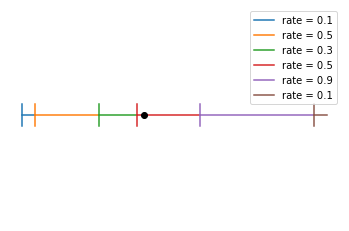

In [2]:
#Show how we select reactions in the Gillespie method.

#Assume we have the following rates...
rates = np.array([0.1, 0.5, 0.3, 0.5, 0.9, 0.1])

#Compute partial sums and total rate...
#In order to be able to select first reaction first element MUST be zero
a = np.concatenate((np.zeros(1), np.cumsum(rates)))
total_a = a[-1]

#Start a figure
plt.figure()
cmap = sns.color_palette()

#Draw all line segments
for j in range(a.size - 1):
    r = rates[j]
    color = cmap.pop(0)
    
    plt.plot((a[j], a[j+1]), (1,1), label=f"rate = {r}", color=color)
    plt.plot((a[j], a[j]), (0.9,1.1))

#Get a random point
random = total_a*np.random.rand()
plt.plot([random], [1], color="black", ls="none", marker="o")
    
#Figure style
plt.ylim(0,2)
plt.legend(loc="best")
sns.despine(left=True, bottom=True)
plt.yticks([])
plt.xticks([])
plt.show()

The pseucode then reads:

1. Take all the rates that describe your system, and sum them all to obtain $a$. Store all partial sums $a_j$ too!
2. Generate a uniform random number $u_1$ between 0 and 1. Calculate

$$
\tau = -\frac{1}{a} \log u_1.
$$

3. Generate another uniform random number $u_2$ between 0 and 1. Then find first element $\mu$ such that $a_j/a > u_2$. Since the array of partial rates is sorted, the most efficient method is _binary search_. This will serve if the first element of the array $a_j$ is 0.

4. Execute the rule that corresponds to reaction $\mu$, and advance $t\to t+\tau$. 
5. Compute the new rates (if they changed) and repeat from first step.

Let's apply the Gillespie algorithm to our simple bacterial population...

Start simulation...
Finished simulation!
First 5 times at which something happened,  [0.01650159 0.02435026 0.04763563 0.05169379 0.05562085]
Last 5 times at which something happened,  [ 99.9891856   99.99491443  99.99818757  99.99853979 100.00567984]


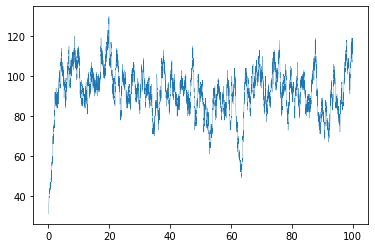

In [3]:
#Simulation parameters
simulation_time = 100.0
lmbda = 1.5 
beta = 1.0 #Death rate fixed to unit time
nR = 300 #Max amount of bacteria

time = np.empty(0)
n_t = np.empty(0)

#Initial conditions 
t = 0.0
n = 30

print("Start simulation...")
while t <= simulation_time:
    rate_grow = lmbda * n * (nR - n) / nR
    rate_die = beta * n
    
    a = rate_grow + rate_die
    
    u1 = np.random.rand() 
    tau = -np.log(u1) / a
    
    #Since we only have two rates, this part is actually super simple! It can be just one or the other
    prob_grow = rate_grow / a
    u2 = np.random.rand()
    
    #Select and execute a reaction
    if u2 < prob_grow:
        #Mu = 0 -> increase bacteria
        n += 1
    else:
        #Mu = 1 -> decrease bacteria
        n -= 1
    #For faster code: n += 2*(u < prob_grow) - 1 instead of the conditionals above

    #Update time and save results
    t += tau
    time = np.append(time, t)
    n_t = np.append(n_t, n)
    
print("Finished simulation!")

print("First 5 times at which something happened, ", time[:5])
print("Last 5 times at which something happened, ", time[-5:])

#Finally plot the time series
plt.figure()
plt.plot(time, n_t, lw=0.3)
plt.show()

In the simulation above, let me remark the following...

- First, the complicated part of selection the reaction was actually quite easy. This is usually the case when we have just two (or even three) reactions. Everything can be done "manually", and it is faster to do so.

- Real computing time can be difficult to stimate. The time step, contrary to fixed step integrators, is of the order of $1/a$, which depends on system rate. Note, however, that this is obtained by summing over the rates of all individuals, so one can assume $a \sim n$, and therefore $dt \sim 1/n$. Simulating large systems, then, can get cumbersome. 

For this last problem, however, we did take a big shortcut: we simplified all the rates of the system into just two global rates. This is not mandatory. We will demonstrate this by making our example more complicated: now, each individual will have a different reproduction rate, $\lambda_j$. And when a bacterium reproduces, the new individual has a reproduction rate $\lambda_j + \gamma g$, where $g$ is a Gaussian random number.

It is possible to simulate this system in several ways. The naive way is assuming that now each individual is different, so separating everything in global rates is gonna be useless. Now we will have to apply the whole procedure, selecting individual by individual, who to reproduce, or who to kill.

In [4]:
%%time
#Simulation parameters
simulation_time = 100.0
mean_lmb, std_lmb = 1.5, 0.1 #Start with a distribution of lambdas...
beta = 1.0 #Death rate fixed to unit time
gamma = 0.05 #Slow mutation
nR = 300 #Max amount of bacteria

time = np.empty(0)
n_t = np.empty(0)

#Initial conditions 
t = 0.0
n = 3
lmbda = np.random.normal(loc=mean_lmb, scale=std_lmb, size=n)

print("Start simulation...")
while t <= simulation_time:
    a = np.zeros(1 + 2*n) #rates start in zero (1) + each bacteria has 2 possible transitions
    
    #Several ways to do this. Here we choose to order this as odd/even for reproduction/death
    #First has to be zero, so we skip it. Counter j updates as j += 2
    #Remember that we store cumulative sum
    for j in range(1, 2*n, 2):
        a[j]   = a[j-1] + lmbda[j//2] * (nR-n)/nR 
        a[j+1] = a[j] + beta 
        
    total_a = a[-1]
    
    u1 = np.random.rand()
    tau = -np.log(u1) / total_a
    
    #Use numpy's searchsorted to find which is the first index. 
    u2 = np.random.rand() * total_a 
    mu = np.searchsorted(a, u2, side="left") - 1
    
    #Since we now how we ordered the partial rates, we DO know which bacteria/reaction we chose just from mu
    bac_index = mu // 2
    reaction = mu % 2
        
    #Execute reaction
    if reaction==0: #Reproduction
        n += 1
        lmbda = np.append(lmbda, lmbda[bac_index] + np.random.normal(loc=0.0, scale=gamma))
    else:
        n -= 1
        lmbda = np.delete(lmbda, bac_index)
        
    #Update time and save results
    t += tau
    time = np.append(time, t)
    n_t = np.append(n_t, n)
    
print("Finished simulation!")

print("First 5 times at which something happened, ", time[:5])
print("Last 5 times at which something happened, ", time[-5:])

#Finally plot the time series
plt.figure()
plt.plot(time, n_t, lw=0.3)
plt.show()

Start simulation...


<timed exec>:30: RuntimeWarning: divide by zero encountered in double_scalars


IndexError: index -1 is out of bounds for axis 0 with size 0

Now the program is way slower. It is not only that as the number of bacteria increases the timestep gets smaller, but also the two loops (the one that computes the rates and the one that performs the search) get considerable longer. 

If you increase, for example, the variance of the distribution, selection pressure increases, making bacteria to evolve faster to better values and making the program slower. 

One way to solve this problem is noticing the following: the death rate can be obtained still as a global rate. Then, a bacteria will die with probability 

$$
p_d = \frac{\Omega(n\to n-1)}{a}
$$

Then, we could greatly simplify the loop, summing just over the $\lambda_j$ rates (which can be done using the `cumsum` function, that is faster!) and then ask: "is someone going to die?". If yes, there is no need to perform any search, since all bacteria die with the same probability.

This is why identifying global rates gives a nice advantage: all the rates that can be somehow "grouped" will allow us to make decisions skipping part of the sum and reducing the number of terms to search, hence greatly reducing the number of iterations of our Gillespie algorithm.

Start simulation...
Finished simulation!
First 5 times at which something happened,  [0.00072486 0.00140301 0.00293441 0.02207259 0.05898696]
Last 5 times at which something happened,  [ 99.97269701  99.97376658  99.99193061  99.99766926 100.00659772]


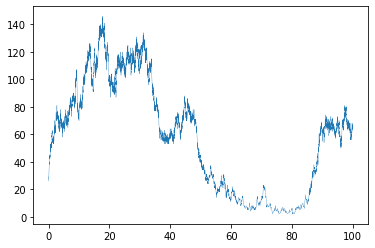

CPU times: user 610 ms, sys: 0 ns, total: 610 ms
Wall time: 608 ms


In [5]:
%%time
#Simulation parameters
simulation_time = 100.0
mean_lmb, std_lmb = 1.5, 0.1 #Start with a distribution of lambdas...
beta = 1.0 #Death rate fixed to unit time
gamma = 0.05 #Slow mutation
nR = 300 #Max amount of bacteria

time = np.empty(0)
n_t = np.empty(0)

#Initial conditions 
t = 0.0
n = 30
lmbda = np.random.normal(loc=mean_lmb, scale=std_lmb, size=n)

print("Start simulation...")
while t <= simulation_time:
    
    #Store only rates for reproduction + zero
    a = np.concatenate((np.zeros(1), np.cumsum(lmbda*(nR-n)/nR)))
    total_death_rate = n*beta 
        
    #Total rate is rate of reproduction (got above) + death 
    total_a = a[-1] + total_death_rate
    prob_death = total_death_rate / total_a 
    
    #Get time
    u1 = np.random.rand()
    tau = -np.log(u1) / total_a
    
    u2 = np.random.rand() 
    #Check if someone is gonna die
    if u2 < prob_death:
        #If yes, directly select a random bacteria to die and execute the reaction
        bac_index = np.random.randint(low=0, high=n)
        lmbda = np.delete(lmbda, bac_index)
        n -= 1
    else:
        #If not, select a random bacteria to reproduce based on its rate
        u3 = np.random.rand() * total_a 
        mu = np.searchsorted(a, u3, side="left") - 1    

        bac_index = mu // 2
        reaction = mu % 2
        
        n += 1
        lmbda = np.append(lmbda, lmbda[bac_index] + np.random.normal(loc=0.0, scale=gamma))

    #Update time and save results
    t += tau
    time = np.append(time, t)
    n_t = np.append(n_t, n)
    
print("Finished simulation!")

print("First 5 times at which something happened, ", time[:5])
print("Last 5 times at which something happened, ", time[-5:])

#Finally plot the time series
plt.figure()
plt.plot(time, n_t, lw=0.3)
plt.show()

Notice that we got almost a 10x speedup from this simple change! So when you plan to simulate a system using the Gillespie algorithm, it really pays off to stop and think how you can group your rates. 

Let me mention you another small example on complex networks where this can be done. Assume that you have a homogeneous network, where all the nodes have degree exactly $k$. Each node receives influence from his neighbours, and its rate depends on this influence: this could be the case of a SIS epidemic model, where the rate of becoming infected depends on the number of infected neighbours.

Since all nodes have the same degree, you now beforehand that each node can only have a discrete set of $1,2,\ldots,k$ infected neighbours. Therefore, a possible Gillespie algorithm would be given from 

0. Loop over all nodes once, counting the number of infected neighbours they have. Store the following lists: (1) a list for each node that details how many infected neighbours they have (2) a list that tells how many nodes we have with 0 infected neighbours, how many with 1, how many with 2, etc. and (3) one dynamic list per each "class" of nodes, so list 1 would have the indices of nodes with 1 infected neighbour, list 2 the indices of nodes with 2 infected neighbours, and so on. This is only done once at the beginning of the program, before starting the loop.
1. Then, we compute the rates. Since we know how many nodes have 1 infected neighbour, the rate of infection of such nodes will be $\lambda n_1$. The rate of infection of nodes with 2 active neighbours will be $2 \lambda n_2$, and so on. 
2. We then have just $k$ global rates. We use the Gillespie method to decide which group of nodes we will update (the one with 1 active neighbours? the group with three?). 
3. Once the group has been decided, all its members have exactly the same probability of being updated. Therefore, extract a random index from the list that contains the members of that group, and make it infected.
4. Do not forget to update the three lists. We only have to check the status of the new node and its neighbours, and make the correspondent update in the lists. 

This method is useful also for networks with certain distribution of degree with not very large $k$, or for lattices. Its benefits are way more measurable for very large networks, since the operations to update the lists might be expensive -but yet cheaper than updating the whole network. 

## Time discretization

Still, sometimes the Gillespie method is just too slow to integrate our system for large times and sizes, and approximated methods need to be used. Then, we can fix the time step to have an approximated method.

The main idea behind this procedure is the following: we know that the distribution between two events is an exponential with certain rate $\lambda$. Then, the probability of an event happening in an interval $[0, \Delta t]$ is given by 

$$
p = \int _0 ^{\Delta t} \lambda \exp(-\lambda t) = 1 - \exp(\lambda \Delta t). 
$$

Therefore, one can just simply loop over the rates of the system and select a reaction with probability $p$. If $\Delta t$ is small enough, the probability can be substituted by its Taylor expansion to make the computation faster,

$$
p \simeq  1 - \lambda \Delta t,
$$

but one has to be careful in the case that the rate depends on system's parameters, since it can then get large and make the expansion inaccurate. This method has the advantage of a fixed $\Delta t$, so no matter how many individuals there are in the system the timestep does not get smaller. However, it makes more difficult to work with global rates, since now in an $\Delta t$ step several reactions can have ocurred. There are two solutions to this problem, 

1. Just loop over all the individuals in the system and perform their reactions individually, without using the global rates.
2. Use some probability theory in order to obtain a way to group the probabilities. Sample the number of ocurrences during this interval and then select random individuals to perform such changes. 

Let's see how to perform the second method. It can get complicated depending on the system, specially when there is spatial or network structure. For instance, our bacteria have two reactions each, and in a windows $\Delta t$ they happen, say with probabilities $p_r$ (reproduce)  or $p_d$ (die). If we have $n$ bacteria, the probability that $m$ of them has reproduced is given by a binomial distribution:

$$
\binom{n}{m} p_r ^m (1-p_r)^{n-m}.
$$

and the same will happen with deaths. Therefore, one can get first two numbers $m_r$ and $m_d$ taken from a binomial distribution, and then execute $m_r$ birth reactions on random individuals and $m_d$ death reactions on random individuals. 

Note that in the cases in which we can apply this method usually one can derive a small set of global rates, making it possible amenable for the Gillespie method. Therefore, the fixed timestep shines specially in the cases where one has no choice but to simulate the full loop over all the individuals to compuate the rates, such as case one. Moreover, the code is very easy to write, which makes a perfect algorithm for fast, low-scale prototypes. Let have here our example with evolving bacteria,

Start simulation...
Finished simulation!
First 5 times at which something happened,  [0.   0.01 0.02 0.03 0.04]
Last 5 times at which something happened,  [99.95 99.96 99.97 99.98 99.99]


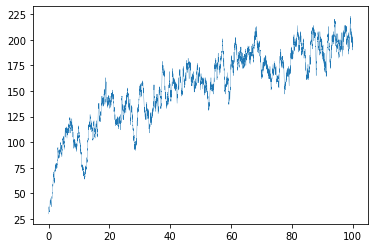

CPU times: user 5.3 s, sys: 15.7 ms, total: 5.32 s
Wall time: 5.23 s


In [6]:
%%time 
#Simulation parameters
simulation_time = 100.0
mean_lmb, std_lmb = 1.5, 0.1 #Start with a distribution of lambdas...
beta = 1.0 #Death rate fixed to unit time
gamma = 0.05 #Slow mutation
dt = 0.01
nR = 300 #Max amount of bacteria

#Initial conditions 
t = 0.0
n = 30
lmbda = np.random.normal(loc=mean_lmb, scale=std_lmb, size=n)

prob_die   = 1.0 - np.exp(-beta*dt) #Precompute for efficiency, since beta is fixed

#These two vectors can be initialised now, since we know how many iterations we do!
time = np.arange(0.0, simulation_time, dt)
n_t = np.empty(time.size)

print("Start simulation...")
for i,t in enumerate(time):

    current_n = n
    to_add = np.empty(0)
    to_kill = np.empty(0, dtype=int)
    for bac_index in range(n):
        prob_repro = 1.0 - np.exp(-lmbda[bac_index]*(nR - n)*dt/nR)
        
        #Select what to do...
        u = np.random.rand()
        #reproduction
        if u <= prob_repro:
            to_add = np.append(to_add, lmbda[bac_index] + np.random.normal(loc=0.0, scale=gamma))
        #die. Observe that we do the sum, (select over segments!!)
        elif u <= prob_repro + prob_die: 
            to_kill = np.append(to_kill, bac_index)
        #Note it CAN happen that this individual does not perform any reaction! There's no problem w that

    #After choosing which reactions to execute, do them
    #Could be done in place too, but pushing/deleting from array we are reading is complicated
    #Also this way we avoid copying the entire array before starting
    lmbda = np.delete(lmbda, to_kill)
    lmbda = np.append(lmbda, to_add)
    
    n += to_add.size - to_kill.size
    
    #Save results
    n_t[i] = n
    
print("Finished simulation!")

print("First 5 times at which something happened, ", time[:5])
print("Last 5 times at which something happened, ", time[-5:])

#Finally plot the time series
plt.figure()
plt.plot(time, n_t, lw=0.3)
plt.show()

Observe that the execution time is comparable to that of the optimized Gillespie algorithm, though we are doing the whole loop over the populaltion, even when we have a small number of bacteria -which tells us that this a fixed-timestep approach can save a lot of time even for the most naive version!!

A final note in all these algorithms: often, the order at which the elements is stored in the arrays is not important. In our population example, it is not important which bacteria is the first or which one is the last. But the numpy `delete` method does conserve the order. So, if we kill the first bacteria of the array, then this is eliminated from memory, and after that the whole array is moved one position forward to re-index it. This is slow for large arrays. In this cases, the following method can be handy:

In [7]:
def fast_delete(x, index):
    x[index] = x[-1] #Overwrite the thing we want to delete with last element
    return x[:-1]    #Return the array except the last element, which will die

This simple method can speed up a lot simple programs that use dynamic memory in intensive way (do **not*** understimate it!!), using it for example in our Gillespie methods.

## 3. Stochastic Differential Equations

For the last part of this tutorial, we will give a small insight on stochastic differential equations (SDEs). First, we will discuss a bit of notation, as well as the issue of intepretation. SDEs are equations of the form 

$$
\frac{dx}{dt} = f(x) + g(x) \xi(t),
$$

and sometimes are written as

$$
dx = f(x) + g(x) dW(t),
$$

where $\xi(t)=dW/dt$ is called Gaussian noise and $W(t)$ is the Wiener process. We will not enter in the details of what the Wiener process is or how the noise works internally -you need to consider it a very _ill-defined_ function. What we do need is to know that the noise is Gaussian, so its described by its first two moments:  

$$ 
\langle \xi(t) \rangle = 0, \\
\langle \xi(t)\xi(t') \rangle = \delta(t-t').
$$

Some authors prefer to write the function $g(x)$ inside of the noise correlation, 

$$ 
\langle \xi(t) \rangle = 0, \\
\langle \xi(t)\xi(t') \rangle = [g(x)]^2 \delta(t-t').
$$

This is specially useful in multidimensional cases, where we can have several noises and the function $g$ gets promoted to a _correlation matrix_ (see also above).

When the function $g$ is a constant, the noise is called additive noise. If not, it is called multiplicative noise. Multiplicative noise can affect even qualitatively the predictions from the deterministic analysis, and it has to be taken with care.

A SDE is not well-defined just by itself. It turns out that the noise so badly defined that the integral of these functions need to be defined. Depending on how this done, one speaks of different _interpretations_ of the SDE. The two most important interpretations are the Ito and the Stratonovich ones. 

### Ito interpretation

This interpretation comes naturally when the noise is internal, from the system. Then, the noise term coming from the microscopic rates before is to be interpreted as Ito. It is the preferred interpretation among many physicists and mathematicians, since it has convenient properties such as $\langle x(t) \xi(t) \rangle = 0$ for any time. 

However, all the rules of calculus in this interpretation do change. The integral of a linear function is no longer a quadratic, and the chain rule for derivatives is also distorted, making computations cumbersome. Suppose that we want to do a change of variable $y=y(x)$. In Ito, the best way to perform such a change is using mathematician's notation,

$$
dy = \frac{dy}{dx} dx + \frac{1}{2} \frac{d^2y}{dx^2} dx^2  
$$

where the equation for $dx$ is above. Note that this is the second-order Taylor expansion, instead of the usual first order. In practice, one subsitutes the equation for $dx$ above and neglects $\mathcal{O}(dW^2)$. Finally, one divides by $dt$ to recover a differential equation for $y$. 

In several variables it is the same, doing the Taylor expansion for the adequate number of dimensions.

### Stratonovich interpretation

Stratonovich is more popular among engineers and some branches of physics. Any noise that is external to the system is to be interpreted in this sense. For example, an experimenter using a random laser to stimulate a cell would be considered Stratonovich, as well as enviromental fluctuations to growth rates of  a rabbid population.In this interpretation, all the rules of calculus stay as we know them, and no additional difficutiles arise. 

### Changing interpretations

Both interpretations are related. If we have an equation interpreted in the Ito sense, we can write an equivalent Stratonovich equation just by doing

$$
\frac{dx_S}{dt} = \frac{dx_I}{dt} - \frac{1}{2} g(x) g'(x).
$$

Therefore, if you are in the Ito interpretation and want to pull out a change of variable, you can also change your equation to Stratonovich, perform the change using the normal rules of calculus, and then go back to Ito.

The Fokker-Planck equation that corresponds to both interpretations is also different! The noise part for the Stratonovich equation is slightly different to the one presented above. 

Notice, moreover, that both interpretations differ in just a term that goes with the derivative of $g(x)$. Thus, in the case of additive noise, there is no difference whatsoever and no distinction between interpretations. Be ware, however, when multiplicative noise is present!

## Numerical integrators 

Having that integrals are different according to our interpretation, again, makes the numerical methods differ for each interpretation. However, as we will see, if we keep the Ito interpretation, things do get greatly simplified.

Let us start with Stratonovich interpretation. Then, the simplest algorithm is an extension to the Euler algorithm called the _Euler-Maruyama_ method,

$$
x_{k+1} = x_k + h f(x_k) + \sqrt{h} g(x_k) u_k + \mathcal{O}(h^{1/2}),   
$$

where $x_k = x(t_k) = x(k h)$, and $u_k$ are Gaussian random variables with mean 0 and unit variance. Please observe that this algorithm has an error way larger than the usual Euler algorithm ($h^{1/2}$ vs $h$) and hence it is strongly discouraged to use it. 

The only place where it is suitable is in the case of additive noise. If $g(x)=\sigma$, then the error is given by $h^{3/2}$, making it even better than the Euler case. If we want to keep this error for the case with multiplicative noise, then we need to resort to the _Milstein_ method,

$$
x_{k+1} = x_k + h f(x_k) + \sqrt{h} g(x_k) u_k + \frac{h}{2} u_k ^2 g(x) g'(x)  + \mathcal{O}(h^{3/2}).   
$$

Given the statistical properties of Gaussian variables, it is possible to set $u_k^2=1$ without losing any convergence. Reordering a bit the new terms, we get

$$
x_{k+1} = x_k + h \left [ f(x_k)  + \frac{1}{2} g(x) g'(x) \right] + \sqrt{h} g(x_k) u_k + \mathcal{O}(h^{3/2}).   
$$

Note that the extra term that appears in the Milstein algorithm is just the change from Stratonovich to Ito. This suggest (correctly!) that Milstein algorithm is basically changing our equation to Ito first and then applying Euler-Maruyama.

In fact, this is true. If our SDE is interpreted in the Ito sense, then the simple Euler-Maruyama algorithm
has a convergence better than the Euler one:

$$
x^I_{k+1} = x^I_k + h f(x^I_k) + \sqrt{h} g(x^I_k) u_k + \mathcal{O}(h^{3/2}).
$$

Higher-order methods are very complicated to obtain, and not so useful in practice. Therefore, the most usual way of integrating SDEs is using the Euler-Maruyama method for Ito-interpreted equations.

## Bacterial population example

We will go back to our bacterial population example. At the beginning we derived the SDEs governing the behaviour of the density of particles. This was given by  

$$
\frac{dx}{dt} = \lambda x (1 - x) - \beta x + \frac{1}{\sqrt{n_R}} \sqrt{\lambda x (1 - x) + \beta x} \xi(t)
$$

and it is to be interpreted in the Ito sense, since it was obtained from microscopic derivation. The square root will prove to be pose problems, so we will discuss a simpler case first to show a complete example. Assume that $n_R \to +\infty$, and the population is so large that its behaviour its deterministic. However, we will imagine that the experimenter has a way to mess with the rate $\beta$, changing it in a random way, so $\beta = \beta + \sigma \eta(t)$, being $\eta(t)$ a white noise. Then, we have

$$
\frac{dx}{dt} = \lambda x (1 - x) - \beta x + \sigma x \eta(t)
$$

and this is to be interpreted in the Stratonovich sense, since we added an external perturbation. Note that if we get $x=0$, so all individuals die, then there is no more fluctuations. This is called an _absorbing state_ in statistical physics. We will change our equation to Ito interpretation. Since $g(x)=\sigma x$, then $g(x) g'(x)/2 = \sigma^2 /2$ and 

$$
\frac{dx}{dt} = \frac{\sigma^2}{2} + \lambda x (1 - x) - \beta x + \sigma x \eta(t)
$$

This is now Ito-interpreted. We can solve the equation now using our simple Euler-Maruyama algorithm! 

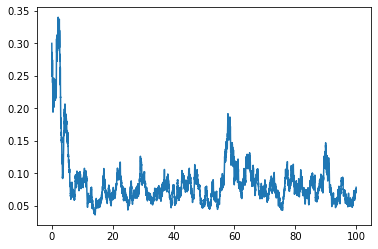

In [8]:
#Simulation parameters
simulation_time = 100.0
lmbda = 0.5
beta = 1.0 #Death rate fixed to unit time
sigma = 0.3
sigma2 = sigma*sigma

dt = 0.01
sqdt = np.sqrt(dt) #Precompute!

time = np.arange(0, simulation_time, dt)
x = np.empty(len(time))

#Initial conditions 
x[0] = 0.3

i = 1
for t in time[1:]:
    fx = 0.5*sigma2 + lmbda*x[i-1]*(1-x[i-1]) - beta*x[i-1] 
    gx = sigma*x[i-1]
    x[i] = x[i-1] + dt*fx + sqdt*gx*np.random.standard_normal()
    i += 1

plt.figure()
plt.plot(time, x)
plt.show()

We observe now a kinda funny effect: we did not clamp our stochastic rate to be always larger than 0. Therefore, $\beta + \eta$ can get negative, making that the "death rate" becomes a positive rate with certain probability. If this probability is enough, the system can always survive.

Let us go to a more cumbersome case. We will integrate our full equation. However, one has to be careful with the square root. Analytically, one can see that states $x<0$ or $x>1$ cannot happen, because the dynamics do stop at those points (also the fluctuations become 0!). However, our discretization allows us to "cross" that value, leading to problems. These problems sometimes can be addressed, building specific integrators for them. The square-root-noise is a typical case, solved by Dornic, Muñoz and collaborators. A simple solution in this cases is just to clamp the value by hand: if we ever get $x<0$, we make $x=0$ and continue integrating. In this case, it would make no sense to have negative densities, so we can then assume that all individuals died and the simulation finished. On the other hand, it is possible to continue integrating if we ever have $x>1$. 

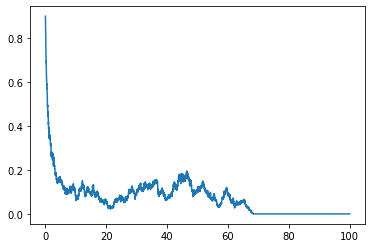

CPU times: user 135 ms, sys: 4.02 ms, total: 139 ms
Wall time: 138 ms


In [9]:
%%time
#Simulation parameters
simulation_time = 100.0
lmbda = 1.05
beta = 1.0 #Death rate fixed to unit time
nR = 300
sigma = 1./np.sqrt(nR) #Noise intensity

dt = 0.01
sqdt = np.sqrt(dt) #Precompute!

time = np.arange(0, simulation_time, dt)
x = np.zeros(len(time))

#Initial conditions 
x[0] = 0.9

i = 1
while i < len(time) and x[i-1] > 0.0:
    growth = lmbda*x[i-1]*(1-x[i-1]) 
    death = beta*x[i-1] 
    fx = growth - death
    gx = sigma * np.sqrt(growth + death)
    x[i] = x[i-1] + dt*fx + sqdt*gx*np.random.standard_normal()
    #x[i] = min(1.0, x[i]) #Cap result to avoid negative sqrt
    i += 1

plt.figure()
plt.plot(time, x)
plt.show()

Notice that despite having a growth rate larger than the death rate, the difference between them is small, so the stationary state is near 0, making possible for the system to die due to fluctuations. The system size is encoded in fluctuation strenght: if `nR` is increased, the fluctuations become weaker, and at some point they will be so small that the system will need practically an infinite time to randomly die. Executing the cell above several times yields different trayectories. One also can increase the growth rate to see how the capping at $x=1$ works. Though, the deterministic dynamics do all they can to prvent the system crossin this threshold, so for most parameter values the capping is almost non needed.

Also, notice that the time to make this simulation is way faster than any microscopic simulation. Hence, if we are interested in macroscopic observables (and most of the times this is our target) integrating the SDE is a very efficient way of getting information from the system. Remember, however, that these are just an approximation for the real microscopic process -although almost always the approximation is so good that there is no actual difference. 

Let us compare this integration with another one that uses additive noise instead. This will lead surely to negative frequencies, since there is nothing in the noise to stop us moving once $x=0$. Although not being realistic, it will serve to see the different features between multiplicative and additive noise. We will still cap the values to 0, because if not crossing the threshold will make the deterministic system go to infinity.

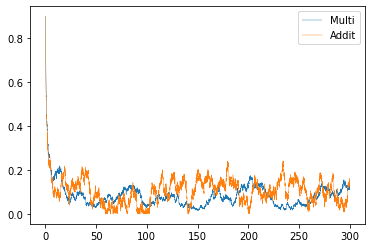

CPU times: user 370 ms, sys: 0 ns, total: 370 ms
Wall time: 369 ms


In [10]:
%%time

#Simulation parameters
simulation_time = 300.0
lmbda = 1.1
beta = 1.0 #Death rate fixed to unit time
nR = 1000
sigma = 1./np.sqrt(nR) #Noise intensity

dt = 0.01
sqdt = np.sqrt(dt) #Precompute!

time = np.arange(0, simulation_time, dt)
x = np.zeros(len(time))
y = np.zeros(len(time)) #Additive noise

#Initial conditions 
x[0] = 0.9
y[0] = 0.9

i = 1
while i < len(time):
    #Multiplicative noise
    growth = lmbda*x[i-1]*(1-x[i-1]) 
    death = beta*x[i-1] 
    fx = growth - death
    gx = sigma * np.sqrt(growth + death)
    x[i] = x[i-1] + dt*fx + sqdt*gx*np.random.standard_normal()
    x[i] = max(0.0, min(1.0, x[i])) #Cap result to avoid negative sqrt
    
    #Additive noise
    growth = lmbda*y[i-1]*(1-y[i-1]) 
    death = beta*y[i-1] 
    fx = growth - death
    gx = sigma 
    y[i] = y[i-1] + dt*fx + sqdt*gx*np.random.standard_normal()
    y[i] = max(0.0, min(1.0, y[i])) #Cap result to avoid negative sqrt

    i += 1

plt.figure()
plt.plot(time, x, label="Multi", lw=0.4)
plt.plot(time, y, label="Addit", lw=0.4)
plt.legend(loc="best")
plt.show()

Here, we have also increased the system size so both lines can survive for longer times. When the growth rate is way larger than the death rate, the system reaches a stationary state and fluctuates around, making both series to look similar: the multiplicative noise will just adapt its amount of fluctuations to those of the stationary state. However, near 0, the situation is different: here, the fluctuations of the multiplicative noise almost vanish, so the system is quite deterministic. But if by chance, fluctuations bring the system up, it becomes more noise. This effect leads to exotic non-equilibrium effects, which have relevance in fields such as neuroscience. 

### Spatial dependence and field theory

As you might have noticed, space was not included in all the examples before. This is because adding a spatial feature in the stochastic system is complicated and needs tougher knowledge of theory. Of course, defining spatial features in the microscopic process is not a problem with Markov processes, but writing a (partial) stochastic differential equation out of them is another story. Often, an easy way to do this is just including a diffusion term in the equation, 

$$
\partial_t \phi(\vec x,t) = f(\phi) + \vec \nabla^2 \phi(\vec x, t) + g(\phi) \eta(\vec x, t).
$$

These equations are to be dealt in the same way as any other PDE, discretizing the derivatives and solving the resulting system of equations for the variables $\phi_j$. In a network, a discretized diffusion operator reads

$$
\vec \nabla^2 \phi \to \frac{1}{k_j} \sum_i A_{ij} (\phi_i - \phi_j).
$$

where $A_{ij}$ is the adjacency matrix and $k_j$ the degree of the $j$ node. Nothing prevents us to assume a "fully-connected" network and study diffusion. This serves usually as a very good approximation to the dynamics on random Erdos-Renyi graphs. Notice that the approaches that we presented before are also adequate for fully-connected systems, but this includes pairwise interactions in a more explicit way macroscopically.  In this case, instead of solving the full equation, one notices that the discretized diffuion can be written as

$$
\vec \nabla^2 \phi = \frac{1}{N} \sum_i (\phi_i - \phi_j) = \bar \phi - \phi_j
$$

being $\bar \phi$ the average of the field in the system. An important remark is that in general one has $\bar \phi \neq \langle \phi \rangle$, but in ergodic systems we can assume them to be equal (and many, many systems are ergodic). However, see that when the diffusion is written in this way, each field $\phi_j$ interacts not with all the others in the networks, but with the average field $\bar \phi$

$$
\partial_t \phi_j = f(\phi_j) + \bar \phi - \phi_j + g(\phi_j) \eta_j
$$

This means that the system can be simulated in a more efficient way (even parallel), skipping the sum over all the possible neighbours, and just computing $\bar \phi$.

1. Compute $\phi_j(t+h)$ from $\phi_j(t)$ and $\bar \phi(t)$ using the Euler-Maruyama method. Add this result to a new variable $\bar \phi (t+h)$.
2. Once the loop has finished, finish the average dividing by the system size $\bar \phi (t+h) = \bar \phi (t+h)/N$, and go to the next step.

Finally, notice that the spatial dependence resulting from the microscopic process does not have to be a diffuion. Many processes work in this way, and it is a good (if not exact) first approximation to study the dynamics. Getting the complete spatial dependence of the system to build a partial SDE is complicated an passes through building a field theory. The interested reader on how to do this might want to look for Doi-Peliti formalism (warning: requires knowledge of quantum creation/annihilation operators and coherent states). 